# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# # load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

#### Loading memory reduced data

In [2]:
# Read data with after memory reduction
azdias = pd.read_csv('Udacity_AZDIAS_reduce_mem_052018.csv')
customers = pd.read_csv('Udacity_CUSTOMERS_reduce_mem_052018.csv')

#Load train and test data after memory reduction
# mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN_reduce_mem.csv')
# mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST_reduce_mem.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Read information on the attributes 
# top-level list of attributes and descriptions, organized by informational category
attributes_des = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
# Detailed mapping of data values for each feature in alphabetical order
attributes_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')

In [4]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
attributes_info.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [79]:
def drop_unnamed_cols(df):
    """
    drop the Unnamed columns in the data

    """
    df.drop(columns=['Unnamed: 0'], inplace=True)
    return df

In [7]:
# drop the unnamed columns
drop_unnamed_cols(azdias)
drop_unnamed_cols(customers)
drop_unnamed_cols(attributes_info)
drop_unnamed_cols(attributes_des)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [8]:
# Fill in the null values in the attribute column
attributes_info["Attribute"] = attributes_info["Attribute"].ffill()
attributes_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


###### Fix the warning received when loading the data

In [ ]:
azdias.columns[19:21]

In [ ]:
customers.columns[19:21]

In [ ]:
azdias['CAMEO_INTL_2015'].unique()

In [ ]:
attributes_info[attributes_info["Attribute"] == "CAMEO_DEUG_2015"]

In [ ]:
# def fix_warnings(df):
#     """
#     Replaces suspicious data with NULL values
    
#     """
#     cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

#     df[cols] = df[cols].replace({'X': np.nan, 'XX':np.nan, '': np.nan, ' ':np.nan})
#     df[cols] = df[cols].astype(float)
       
#     return df

In [9]:
# Replaces suspicious data with NULL values.
azdias[['CAMEO_DEUG_2015']] = azdias[['CAMEO_DEUG_2015']].replace(['X'],np.NaN)
azdias[['CAMEO_DEUG_2015']] = azdias[['CAMEO_DEUG_2015']].replace(['XX','X'],np.NaN)
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)

In [10]:
azdias[['CAMEO_INTL_2015']] = azdias[['CAMEO_INTL_2015']].replace(['X'],np.NaN)
azdias[['CAMEO_INTL_2015']] = azdias[['CAMEO_INTL_2015']].replace(['XX','X'],np.NaN)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)

In [11]:
# Replaces suspicious data with NULL values.
customers[['CAMEO_DEUG_2015']] = customers[['CAMEO_DEUG_2015']].replace(['X'],np.NaN)
customers[['CAMEO_DEUG_2015']] = customers[['CAMEO_DEUG_2015']].replace(['XX','X'],np.NaN)
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].astype(float)

In [12]:
customers[['CAMEO_INTL_2015']] = customers[['CAMEO_INTL_2015']].replace(['X'],np.NaN)
customers[['CAMEO_INTL_2015']] = customers[['CAMEO_INTL_2015']].replace(['XX','X'],np.NaN)
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].astype(float)

###### Find features that we don't have any information and drop
Find the features that is in Azdias but not in attributes_val, features that we don't have information about

In [ ]:
# Features we have information
attributes_list = attributes_info['Attribute'].unique()
print(len(attributes_list))
print(attributes_list)

In [ ]:
# features in azdias that we don't have information
feat_no_info = list(set(azdias) - set(attributes_list))
print(feat_no_info)
len(feat_no_info)

In [ ]:
# features with information but not in azdias
feat_not_azdias = list(set(attributes_list) - set(azdias))
print(len(feat_not_azdias))
print(feat_not_azdias)

In [ ]:
feat_no_info_df = pd.DataFrame(feat_no_info)
feat_no_azdias_df = pd.DataFrame(feat_not_azdias)

In [ ]:
missing_info = [feat_no_info_df, feat_no_azdias_df]
missing_info_df = pd.concat(missing_info, axis=1)
missing_info_df

In [ ]:
missing_info_df.to_excel('no_information.xlsx')

After analysing the 'no_information.xlsx', i found that there are feature, that end with _RZ as thus I have kept them and only drop the one we don't have any information 'drop_col_no_info.xlsx'

In [13]:
drop_col_no_info = pd.read_excel('drop_col_no_info.xlsx')
drop_col_no_info

,no_info
0,AKT_DAT_KL
1,ALTER_KIND1
2,ALTER_KIND2
3,ALTER_KIND3
4,ALTER_KIND4
5,ALTERSKATEGORIE_FEIN
6,ANZ_KINDER
7,ANZ_STATISTISCHE_HAUSHALTE
8,ARBEIT
9,CJT_KATALOGNUTZER


In [14]:
dropping_cols = list(drop_col_no_info['no_info'].unique())
dropping_cols

['AKT_DAT_KL',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_KONSUMTYP_MAX',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSI_ONLINE_QUOTE_12',
 'DSL_FLAG',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'FIRMENDICHTE',
 'GEMEINDETYP',
 'HH_DELTA_FLAG',
 'KBA13_ANTG1',
 'KBA13_ANTG2',
 'KBA13_ANTG3',
 'KBA13_ANTG4',
 'KBA13_BAUMAX',
 'KBA13_GBZ',
 'KBA13_HHZ',
 'KBA13_KMH_210',
 'KOMBIALTER',
 'KONSUMZELLE',
 'LNR',
 'MOBI_RASTER',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'UNGLEICHENN_FLAG',
 'VERDICHTUNGSRAUM',
 'VHA',
 'VHN',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11']

In [14]:
len(dropping_cols)

56

In [15]:
azdias.drop(dropping_cols, axis=1, inplace=True)

In [16]:
customers.drop(dropping_cols, axis=1, inplace=True)

In [17]:
print(azdias.shape)
print(customers.shape)

(891221, 310)
(191652, 313)


##### Look at the extra columnns in customers

In [ ]:
customers['PRODUCT_GROUP'].unique()

In [ ]:
customers['ONLINE_PURCHASE'].describe()

In [ ]:
customers['CUSTOMER_GROUP'].unique()

In [ ]:
# Drop the additional columns
customers.drop(['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP'],axis=1,inplace=True)

In [19]:
print(azdias.shape)
print(customers.shape)

(891221, 310)
(191652, 310)


In [ ]:

# Copy datasets before data transformation
azdias_co = azdias.copy()
customers_co= customers.copy()

#### Looking at the missing values

In [20]:
# Attributes with missing or unknown
unknowns = []
for attribute in attributes_info['Attribute'].unique():
    _ = attributes_info.loc[attributes_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    _ = _.split(',')
    unknowns.append(_)
    
unknowns = pd.concat([pd.Series(attributes_info['Attribute'].unique()), pd.Series(unknowns)], axis=1)
unknowns.columns = ['attribute', 'missing_or_unknown']
print(unknowns)

                      attribute  \
0                      AGER_TYP   
1          ALTERSKATEGORIE_GROB   
2                      ALTER_HH   
3                     ANREDE_KZ   
4           ANZ_HAUSHALTE_AKTIV   
5                  ANZ_HH_TITEL   
6                  ANZ_PERSONEN   
7                     ANZ_TITEL   
8                      BALLRAUM   
9                      BIP_FLAG   
10              CAMEO_DEUG_2015   
11               CAMEO_DEU_2015   
12           CAMEO_DEUINTL_2015   
13                CJT_GESAMTTYP   
14            D19_BANKEN_ANZ_12   
15            D19_BANKEN_ANZ_24   
16             D19_BANKEN_DATUM   
17         D19_BANKEN_DIREKT_RZ   
18          D19_BANKEN_GROSS_RZ   
19          D19_BANKEN_LOKAL_RZ   
20     D19_BANKEN_OFFLINE_DATUM   
21      D19_BANKEN_ONLINE_DATUM   
22   D19_BANKEN_ONLINE_QUOTE_12   
23           D19_BANKEN_REST_RZ   
24        D19_BEKLEIDUNG_GEH_RZ   
25       D19_BEKLEIDUNG_REST_RZ   
26               D19_BILDUNG_RZ   
27              D19_

In [21]:
# creating a dataframe to get count/percentage of missing values in azdias and customers
azdias_nan=pd.DataFrame(azdias.isna().sum(axis=0)).reset_index()
azdias_nan.columns=['column','azdias_nan']
azdias_nan['azdiaz_nan_percent']=(azdias_nan['azdias_nan']/len(azdias))*100

customers_nan=pd.DataFrame(customers.isna().sum(axis=0)).reset_index()
customers_nan.columns=['column','customers_nan']
customers_nan['customer_nan_percent']=(customers_nan['customers_nan']/len(customers))*100
missing_values=pd.merge(azdias_nan, customers_nan, on='column')
missing_values=missing_values.sort_values(by=['azdias_nan','customers_nan'],ascending=[False,False])
missing_values

,column,azdias_nan,azdiaz_nan_percent,customers_nan,customer_nan_percent
260,KK_KUNDENTYP,584612,65.596749,111937,58.406382
19,D19_BANKEN_ONLINE_QUOTE_12,257113,28.849522,47697,24.887296
36,D19_GESAMT_ONLINE_QUOTE_12,257113,28.849522,47697,24.887296
40,D19_KONSUMTYP,257113,28.849522,47697,24.887296
43,D19_LOTTO,257113,28.849522,47697,24.887296
64,D19_VERSAND_ONLINE_QUOTE_12,257113,28.849522,47697,24.887296
87,KBA05_ALTER1,133324,14.959701,55980,29.209192
88,KBA05_ALTER2,133324,14.959701,55980,29.209192
89,KBA05_ALTER3,133324,14.959701,55980,29.209192
90,KBA05_ALTER4,133324,14.959701,55980,29.209192


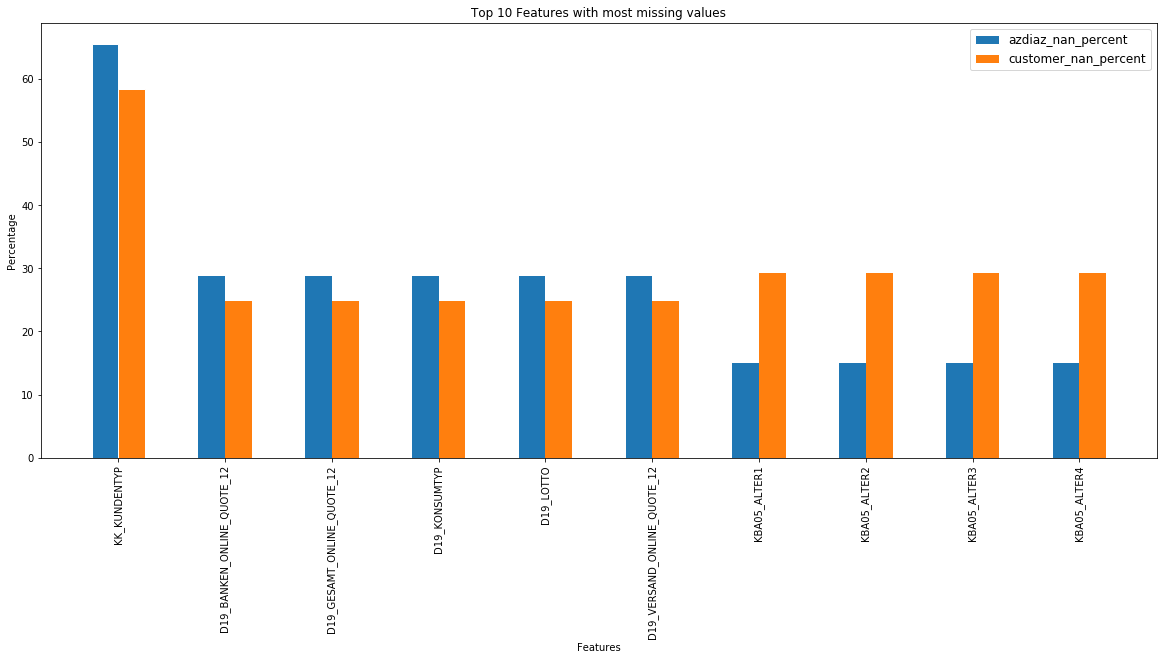

In [22]:
plt.figure(figsize=(20,8))
# set width of bar
barWidth = 0.25
# set height of bar
bars1 = missing_values['azdiaz_nan_percent'][:10]
bars2 = missing_values['customer_nan_percent'][:10]
label=missing_values['column'][:10]
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white')
plt.bar(r2, bars2, width=barWidth, edgecolor='white')

 
# Add xticks on the middle of the group bars
plt.xlabel('Features')
plt.ylabel('Percentage')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], label,rotation=90)
 
# Create legend & Show graphic
plt.title('Top 10 Features with most missing values')
plt.legend(['azdiaz_nan_percent','customer_nan_percent'],prop={'size': 12})
plt.show()

In [ ]:
# we will drop the columns with highest missing value
# Only the first variable has more than 60% missing value
drop_cols=list(label[:1])
drop_cols

###### Missing value in Columns

In [ ]:

# removing rows having retension percentage less than 94%
new_azdias=azdias[azdias.isnull().sum(axis=1)<=20]

new_customers=customers[customers.isnull().sum(axis=1)<=20]

Text(0.5,0,'Percent of missing values')

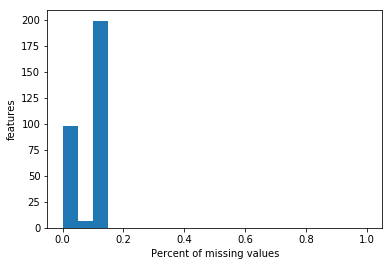

In [42]:
#looking for nans in columns
column_nans = azdias.isnull().mean()
plt.hist(column_nans, bins = np.arange(0,1+.05,.05))
plt.ylabel('features')
plt.xlabel('Percent of missing values')

In [43]:
# drop columns with top 20% missing value
col_drops = column_nans[column_nans>0.2].index

In [44]:
col_drops

Index([], dtype='object')

In [29]:
azdias.drop(col_drops,axis=1,inplace=True)

In [45]:
customers.drop(col_drops,axis=1,inplace=True)

In [46]:
print(azdias.shape)
print(customers.shape)

(891221, 304)
(191652, 310)


###### Missing value in rows

Text(0.5,0,'prop. of missing values')

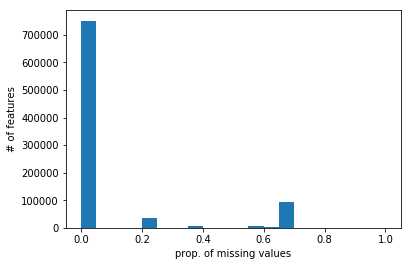

In [47]:
rows_nans = azdias.isnull().mean(axis=1)
plt.hist(rows_nans, bins = np.arange(0,1+.05,.05))
plt.ylabel('# of features')
plt.xlabel('prop. of missing values')

In [48]:
# Drop Rows
drop_rows = rows_nans[rows_nans>=0.2].index
azdias.drop(drop_rows,axis=0,inplace=True)

In [49]:
rows_nans = customers.isnull().mean(axis=1);
drop_rows = rows_nans[rows_nans>=0.2].index
customers.drop(drop_rows,axis=0,inplace=True)

In [50]:
print(azdias.shape)
print(customers.shape)

(751331, 304)
(135144, 310)


###### Drop Correlated features above threshold of 75%

In [ ]:
# find correlation matrix and drop variables with greater than 75% correlation  
corr_matrix = azdias.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .75)]

In [ ]:
drop_columns

In [ ]:
azdias.drop(drop_columns,axis=1,inplace=True)

In [ ]:
customers.drop(drop_columns,axis=1,inplace=True)

In [ ]:
print(azdias.shape)
print(customers.shape)

##### Check categorical variables

In [ ]:
# Getting all numeric columns and categorical columns
Numeric_columns=azdias.select_dtypes(include=np.number).columns.tolist()
categorical_col=set(azdias.columns).difference(set(Numeric_columns))
print("Length of Numeric columns in azdias",len(Numeric_columns))
print("Length of categorical columns in azdias",len(categorical_col))
print("Categorial columns in azdias are",categorical_col)

In [ ]:
# Getting all numeric columns and categorical columns
Numeric_columns=customers.select_dtypes(include=np.number).columns.tolist()
categorical_col=set(customers.columns).difference(set(Numeric_columns))
print("Length of Numeric columns in customers",len(Numeric_columns))
print("Length of categorical columns in customers",len(categorical_col))
print("Categorial columns in customers are",categorical_col)

In [ ]:
azdias['CAMEO_DEU_2015'].unique()

In [ ]:
azdias['CAMEO_DEU_2015'].value_counts()

In [ ]:
azdias['OST_WEST_KZ'].unique()

In [ ]:
azdias['OST_WEST_KZ'].value_counts()

In [ ]:
azdias[['CAMEO_DEU_2015']]=azdias[['CAMEO_DEU_2015']].replace(['X','XX'],np.NaN)
azdias['CAMEO_DEUG_2015']=azdias['CAMEO_DEUG_2015'].apply(pd.to_numeric)

In [ ]:
customers[['CAMEO_DEU_2015']]=customers[['CAMEO_DEU_2015']].replace(['X','XX'],np.NaN)
customers['CAMEO_DEUG_2015']=customers['CAMEO_DEUG_2015'].apply(pd.to_numeric)

In [ ]:
azdias['CAMEO_DEU_2015'].unique()

In [ ]:
# Getting all numeric columns and categorical columns
Numeric_columns=azdias.select_dtypes(include=np.number).columns.tolist()
categorical_col=set(azdias.columns).difference(set(Numeric_columns))
print("Length of Numeric columns in azdias",len(Numeric_columns))
print("Length of categorical columns in azdias",len(categorical_col))
print("Categorial columns in azdias are",categorical_col)

In [ ]:
# Getting all numeric columns and categorical columns
Numeric_columns=customers.select_dtypes(include=np.number).columns.tolist()
categorical_col=set(customers.columns).difference(set(Numeric_columns))
print("Length of Numeric columns in customers",len(Numeric_columns))
print("Length of categorical columns in customers",len(categorical_col))
print("Categorial columns in customers are",categorical_col)

###### Replacing NAN  - forward fill with mode

In [ ]:
azdias=azdias.fillna(azdias.mode().iloc[0])
customers=customers.fillna(customers.mode().iloc[0])

In [ ]:
# Check NULL values in dataframes
print("Missing values in Azdias dataset AFTER cleaning:", azdias_clean.isnull().sum().sum())
print("Missing values in Customers dataset AFTER cleaning:", customers_clean.isnull().sum().sum())

In [ ]:
print(azdias.shape)
print(customers.shape)

##### One-hot encoding categorical variables

In [ ]:
azdias=pd.get_dummies(azdias)
customers=pd.get_dummies(customers)

In [ ]:
print(azdias.shape)
print(customers.shape)

###### Save the cleaned data

In [ ]:
azdias.to_csv('azdias_clean.csv')
customers.to_csv('customers_clean.csv')


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

######  Load the cleaned data

In [2]:
azdias = pd.read_csv('azdias_clean.csv')

In [3]:
azdias.head()

,Unnamed: 0,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
0,1,-1,0.0,11.0,0.0,2.0,0.0,6.0,8.0,5.0,...,0,0,0,0,0,0,0,0,0,1
1,2,-1,17.0,10.0,0.0,1.0,0.0,2.0,4.0,3.0,...,0,0,0,0,0,0,0,0,0,1
2,3,2,13.0,1.0,0.0,0.0,0.0,4.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,1
3,4,-1,20.0,3.0,0.0,4.0,0.0,2.0,6.0,5.0,...,0,0,0,0,0,0,0,0,0,1
4,5,3,10.0,5.0,0.0,1.0,0.0,6.0,8.0,2.0,...,0,1,0,0,0,0,0,0,0,1


In [4]:
customers = pd.read_csv('customers_clean.csv')

In [5]:
customers.head()

,Unnamed: 0,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
0,0,2,10.0,1.0,0.0,2.0,0.0,3.0,1.0,5.0,...,0,0,0,0,0,0,0,0,0,1
1,2,-1,6.0,1.0,0.0,1.0,0.0,7.0,5.0,2.0,...,0,0,0,0,0,0,0,0,0,1
2,3,1,8.0,0.0,0.0,0.0,0.0,7.0,4.0,2.0,...,0,0,0,0,0,0,0,0,0,1
3,4,-1,20.0,7.0,0.0,4.0,0.0,3.0,7.0,6.0,...,0,0,0,0,0,0,0,0,0,1
4,5,1,11.0,1.0,0.0,2.0,0.0,7.0,5.0,4.0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# drop the unnamed columns
drop_unnamed_cols(azdias)
drop_unnamed_cols(customers)

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
0,2,10.0,1.0,0.0,2.0,0.0,3.0,1.0,5.0,0,...,0,0,0,0,0,0,0,0,0,1
1,-1,6.0,1.0,0.0,1.0,0.0,7.0,5.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,8.0,0.0,0.0,0.0,0.0,7.0,4.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
3,-1,20.0,7.0,0.0,4.0,0.0,3.0,7.0,6.0,1,...,0,0,0,0,0,0,0,0,0,1
4,1,11.0,1.0,0.0,2.0,0.0,7.0,5.0,4.0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135139,1,9.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,0,...,0,0,0,0,0,0,0,0,0,1
135140,-1,0.0,0.0,0.0,0.0,0.0,6.0,5.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
135141,2,15.0,1.0,0.0,3.0,0.0,7.0,4.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
135142,3,13.0,4.0,0.0,4.0,0.0,3.0,4.0,4.0,1,...,0,0,0,0,0,0,0,0,0,1


In [9]:
azdias.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
0,-1,0.0,11.0,0.0,2.0,0.0,6.0,8.0,5.0,0,...,0,0,0,0,0,0,0,0,0,1
1,-1,17.0,10.0,0.0,1.0,0.0,2.0,4.0,3.0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,13.0,1.0,0.0,0.0,0.0,4.0,2.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
3,-1,20.0,3.0,0.0,4.0,0.0,2.0,6.0,5.0,3,...,0,0,0,0,0,0,0,0,0,1
4,3,10.0,5.0,0.0,1.0,0.0,6.0,8.0,2.0,0,...,0,1,0,0,0,0,0,0,0,1


In [10]:
customers.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,OST_WEST_KZ_O,OST_WEST_KZ_W
0,2,10.0,1.0,0.0,2.0,0.0,3.0,1.0,5.0,0,...,0,0,0,0,0,0,0,0,0,1
1,-1,6.0,1.0,0.0,1.0,0.0,7.0,5.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,8.0,0.0,0.0,0.0,0.0,7.0,4.0,2.0,0,...,0,0,0,0,0,0,0,0,0,1
3,-1,20.0,7.0,0.0,4.0,0.0,3.0,7.0,6.0,1,...,0,0,0,0,0,0,0,0,0,1
4,1,11.0,1.0,0.0,2.0,0.0,7.0,5.0,4.0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
print(azdias.shape)
print(customers.shape)

(751329, 284)
(135144, 284)


###### Standardizing the Dataset

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias)
customers_scaled = scaler.transform(customers)

In [14]:
print(azdias.shape)
print(customers.shape)

(751329, 284)
(135144, 284)


##### Dimensionality Reduction - PCA

In [15]:
pca=PCA()
pca.fit(azdias_scaled)

PCA()

In [16]:
pca.explained_variance_ratio_[:6]

array([0.05885439, 0.05564926, 0.04468692, 0.03174779, 0.02614661,
       0.02364647])

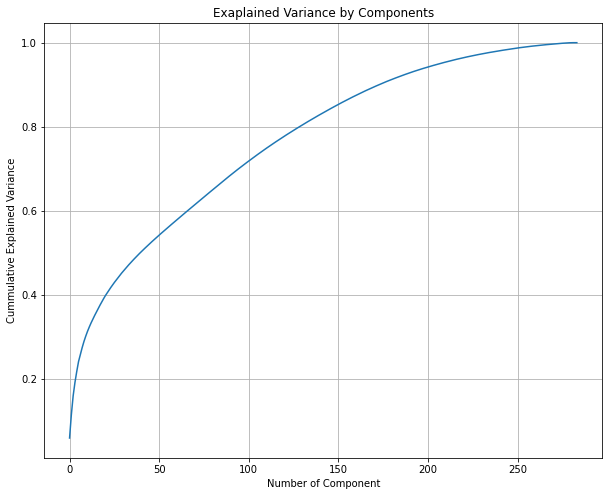

In [17]:
plt.figure(figsize=(10,8))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title("Exaplained Variance by Components")
plt.xlabel("Number of Component")
plt.ylabel("Cummulative Explained Variance")
plt.grid(True)
plt.show()

In [18]:
pca = PCA(n_components=200)
pca_azdias = pca.fit_transform(azdias_scaled)
pca_azdias = pd.DataFrame(pca_azdias)

In [19]:
pca_customers = pca.transform(customers_scaled)
pca_customers = pd.DataFrame(pca_customers)

In [20]:
# shape of reduced components
print(pca_azdias.shape)
print(pca_customers.shape)

(751329, 200)
(135144, 200)


In [21]:
pca

PCA(n_components=200)

##### K-Means Clustering

Determine the number of clusters

In [22]:
pca_azdias_sample=pca_azdias.sample(20000)

In [23]:
# Determine the Within Cluster Sum of Squares (WCSS) for each solution
wcss=[]
score=[]
for i in range(1,21):
    #print(i)
    kmeans_pca=KMeans(n_clusters=i,init='k-means++',random_state=42)
    model=kmeans_pca.fit(pca_azdias_sample)
    wcss.append(model.inertia_)

In [ ]:
 figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(K, inertias, '-o', color='black')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(K)
    plt.show()

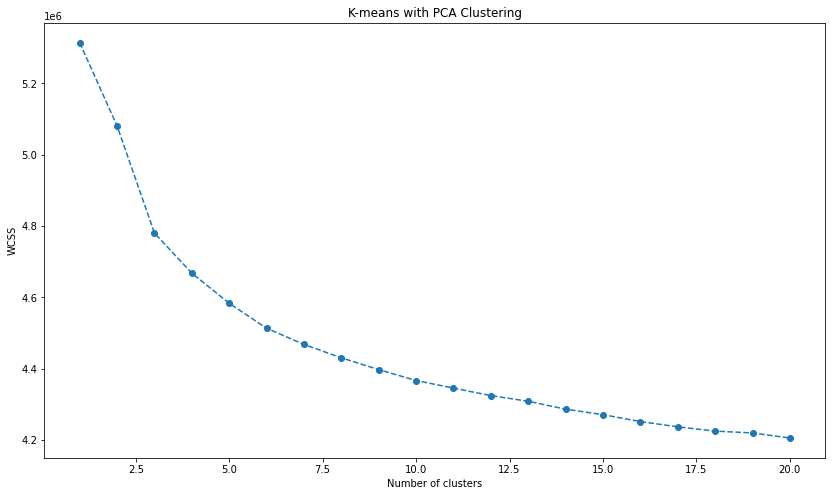

In [56]:
# Ploting the wcss againts the number of component
plt.figure(figsize=(14,8))
plt.plot(range(1,21),wcss,marker='o',linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

According to the Elbow method, look like cluster 3-6

In [57]:
kmeans = KMeans(3)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

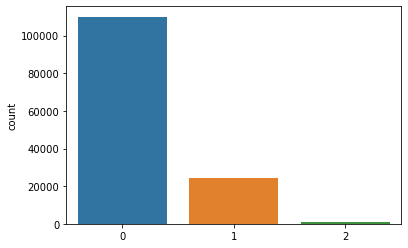

In [58]:
sns.countplot(prediction_customers)


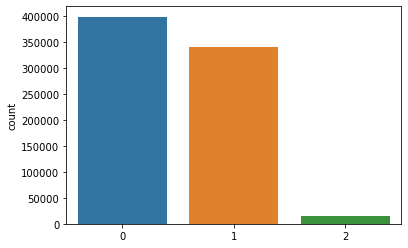

In [59]:
sns.countplot(prediction_azdias)

In [60]:
kmeans = KMeans(4)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

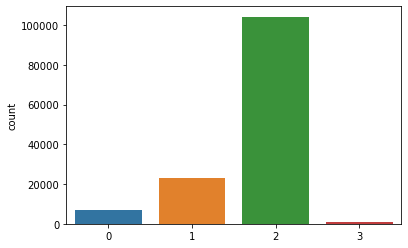

In [61]:
sns.countplot(prediction_customers)

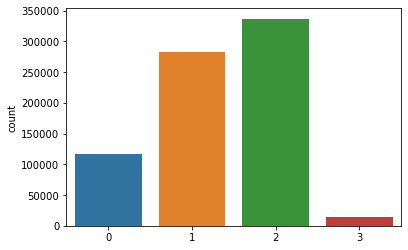

In [62]:
sns.countplot(prediction_azdias)

In [63]:
kmeans = KMeans(5)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

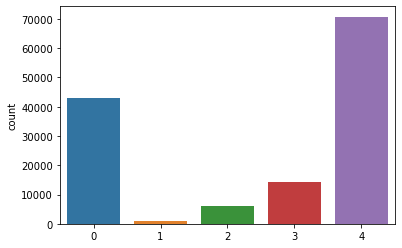

In [64]:
sns.countplot(prediction_customers)

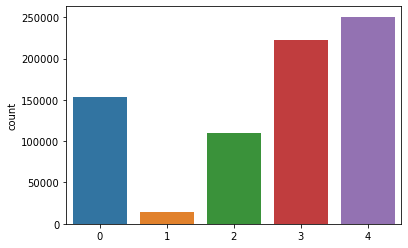

In [65]:
sns.countplot(prediction_azdias)

In [66]:
kmeans = KMeans(6)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

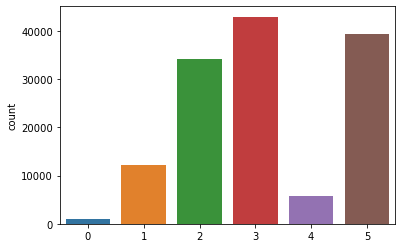

In [67]:
sns.countplot(prediction_customers)

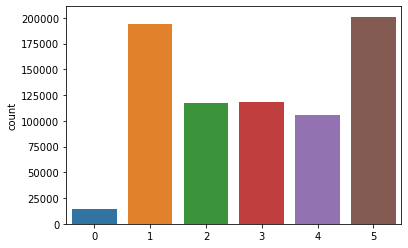

In [68]:
sns.countplot(prediction_azdias)

In [69]:
kmeans = KMeans(7)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

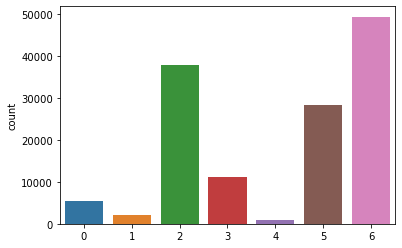

In [70]:
sns.countplot(prediction_customers)

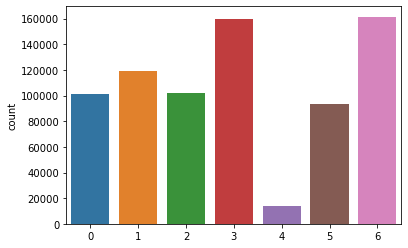

In [71]:
sns.countplot(prediction_azdias)

In [75]:
kmeans = KMeans(6)
model = kmeans.fit(pca_azdias)
prediction_azdias = model.predict(pca_azdias)
prediction_customers = model.predict(pca_customers)

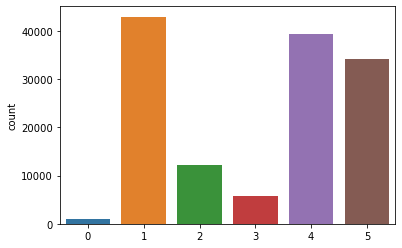

In [76]:
sns.countplot(prediction_customers)

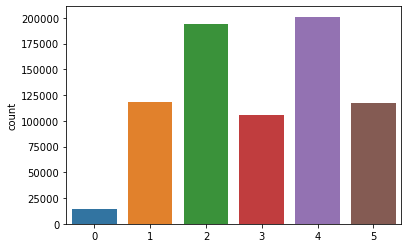

In [77]:
sns.countplot(prediction_azdias)

K=6 seems to be the best choice

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [78]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN_reduce_mem.csv')
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST_reduce_mem.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [80]:
mailout_test.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [81]:
drop_unnamed_cols(mailout_train)
drop_unnamed_cols(mailout_test)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,67615,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1
42829,67938,0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,2.0,...,4.0,10.0,9.0,6.0,6.0,9.0,3.0,3,1,4
42830,67942,-1,1.0,16.0,14.0,17.0,NaN,NaN,15.0,1.0,...,2.0,1.0,1.0,1.0,1.0,9.0,3.0,2,1,3
42831,67949,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,1.0,4.0,4.0,2.0,6.0,9.0,3.0,3,2,3


In [82]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')